# CARE Prediction
Please run the `1_CARETraining.ipynb` notebook before going through this notebook.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sys
sys.path.append('../')
import torch
from tifffile import imread

from unet.model import UNet
from pn2v.utils import denormalize
from pn2v.utils import normalize
from pn2v.utils import PSNR
from pn2v import utils
from pn2v import prediction
import pn2v.training
from pn2v import histNoiseModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Data Dir and Model Dir

In [2]:
DATA_DIR='/opt/dkube/input'
MODEL_DIR='/opt/dkube/output'

### Load Test Data

In [3]:
# Load the test data
dataTest=imread(DATA_DIR+"/20190520_tl_25um_50msec_05pc_488_130EM_Conv.tif")[:,:512,:512] 
# We are loading only a sub image to spped up computation

# We estimate the ground truth by averaging.
dataTestGT=np.mean(dataTest[:,...],axis=0)[np.newaxis,...]


### Load the Network and Noise Model
Ensure that ```dataName``` is set same as in ```1_CareTraining.ipynb```.

In [4]:
dataName = 'convallaria' # Use the same name as used in 1_CareTraining.ipynb. This is a part of model name created in 1_CareTraining.ipynb 
nameModel=dataName+'_care'

In [5]:
## Load the model
model = UNet(1,depth=3)
model.load_state_dict(torch.load(MODEL_DIR+'/model.pt'))
model.eval()

../../../../unet/model.py:215: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  init.xavier_normal(m.weight)
../../../../unet/model.py:216: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  init.constant(m.bias, 0)


UNet(
  (conv_final): Conv2d(64, 1, kernel_size=(1, 1), stride=(1, 1))
  (down_convs): ModuleList(
    (0): DownConv(
      (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): DownConv(
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): DownConv(
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    )
  )
  (up_convs): ModuleList(
    (0): UpConv(
      (upconv): ConvTranspose2d(256, 128, kernel_size=(2, 2), stride=(2, 2))
      (conv1): Conv2d(128, 128, 

### Evaluation

image: 0
PSNR input 29.009240856174337
PSNR CARE 35.228872850576025
-----------------------------------
image: 1
PSNR input 29.018589127299936
PSNR CARE 35.184560083070565
-----------------------------------
image: 2
PSNR input 29.035458856560645
PSNR CARE 35.187487923116294
-----------------------------------
image: 3
PSNR input 28.990347509982925
PSNR CARE 35.24528120443169
-----------------------------------
image: 4
PSNR input 29.002852113680238
PSNR CARE 35.233393119743084
-----------------------------------
image: 5
PSNR input 29.02402327393454
PSNR CARE 35.21195505793686
-----------------------------------
image: 6
PSNR input 29.032053580418268
PSNR CARE 35.20626596463619
-----------------------------------
image: 7
PSNR input 29.017435705343363
PSNR CARE 35.23917992028508
-----------------------------------
image: 8
PSNR input 29.003677692102134
PSNR CARE 35.29736826993095
-----------------------------------
image: 9
PSNR input 28.991348421709475
PSNR CARE 35.18008296650404
---

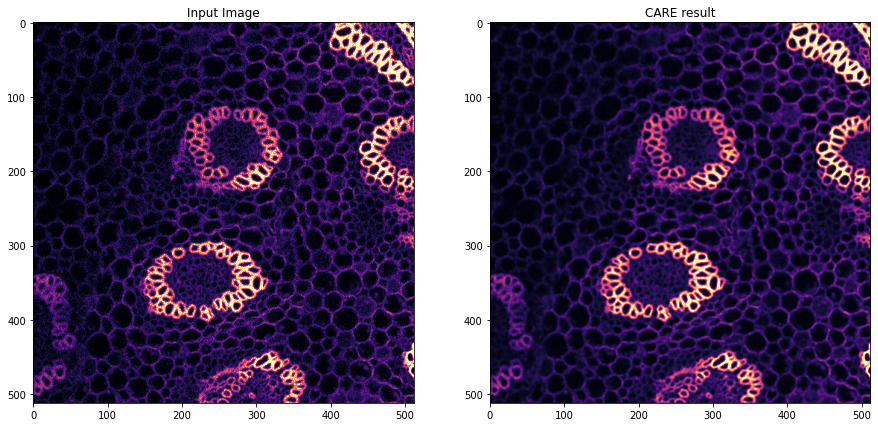

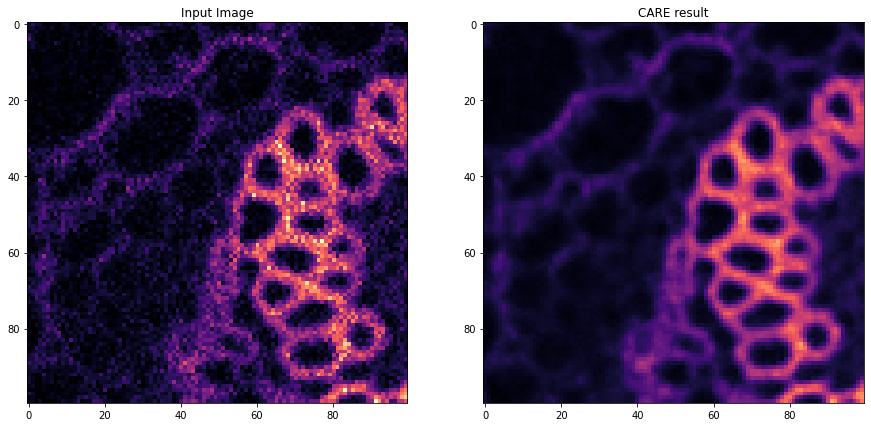

Avg PSNR CARE: 35.250210952851305 +-(2SEM) 0.00864318581601545


In [6]:
# Now we are processing data and calculating PSNR values.
careRes=[]
resultImgs=[]
inputImgs=[]

# We iterate over all test images.
for index in range(dataTest.shape[0]):
    
    im=dataTest[index]
    gt=dataTestGT[0] # The ground truth is the same for all images
    
    # We are using tiling to fit the image into memory
    # If you get an error try a smaller patch size (ps)
    careResult = prediction.tiledPredict(im, model ,ps=256, overlap=48,
                                            device=device, noiseModel=None)
    
    
    inputImgs.append(im)

    rangePSNR=np.max(gt)-np.min(gt)
    carePrior=PSNR(gt, careResult, rangePSNR )
    careRes.append(carePrior)

    print ("image:",index)
    print ("PSNR input", PSNR(gt, im, rangePSNR))
    print ("PSNR CARE", carePrior) # Without info from masked pixel
    print ('-----------------------------------')
    
    
# We display the results for the last test image       
vmi=np.percentile(gt,0.01)
vma=np.percentile(gt,99)

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im, vmax=vma, vmin=vmi, cmap='magma')

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult, vmax=vma, vmin=vmi, cmap='magma')

plt.figure(figsize=(15, 15))
plt.subplot(1, 2, 1)
plt.title(label='Input Image')
plt.imshow(im[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/raw_image.png', im[100:200,150:250])

plt.subplot(1, 2, 2)
plt.title(label='CARE result')
plt.imshow(careResult[100:200,150:250], vmax=vma, vmin=vmi, cmap='magma')
#plt.imsave('../../../imgs/CARE_denoised_image.png', careResult[100:200,150:250])
plt.show()

print("Avg PSNR CARE:", np.mean(np.array(careRes) ), '+-(2SEM)',2*np.std(np.array(careRes) )/np.sqrt(float(len(careRes)) ) )